### Importing Necessary Packages

In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


c:\Users\ariga\Documents\sqlenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset Preaparation and Preprocessing

In [2]:

# Load the Twitter Financial Sentiment Dataset
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")

print(dataset)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})


In [3]:
train_data = dataset['train']
validation_data = dataset['validation']

# Extract features (text) and labels
X_train = train_data['text']
y_train = train_data['label']
X_val = validation_data['text']
y_val = validation_data['label']
 
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 9543
Validation set size: 2388


In [4]:
print(X_train)

['$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT', '$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3', '$CX - Cemex cut at Credit Suisse, J.P. Morgan on weak building outlook https://t.co/KN1g4AWFIb', '$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N', '$FNKO - Funko slides after Piper Jaffray PT cut https://t.co/z37IJmCQzB', '$FTI - TechnipFMC downgraded at Berenberg but called Top Pick at Deutsche Bank https://t.co/XKcPDilIuU', '$GM - GM loses a bull https://t.co/tdUfG5HbXy', '$GM: Deutsche Bank cuts to Hold https://t.co/7Fv1ZiFZBS', '$GTT: Cowen cuts to Market Perform', '$HNHAF $HNHPD $AAPL - Trendforce cuts iPhone estimate after Foxconn delay https://t.co/rlnEwzlzzS', "$HOG - Moody's warns on Harley-Davidson https://t.co/LurHBEadeU", '$HXL - Citing aero ties, Wells slashes PT on Hexcel https://t.co/wU5P2i8WBU', '$I - Intelsat cut to Market Perform at Raymond James https://t.co/YsvsMSQRIb

In [5]:
print(type(y_train))
print(set(y_train))

<class 'list'>
{0, 1, 2}


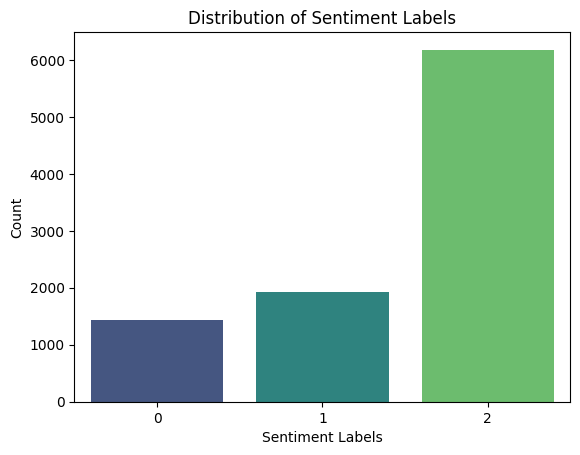

In [6]:
sns.countplot(x=y_train,palette="viridis",hue=None)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.show()

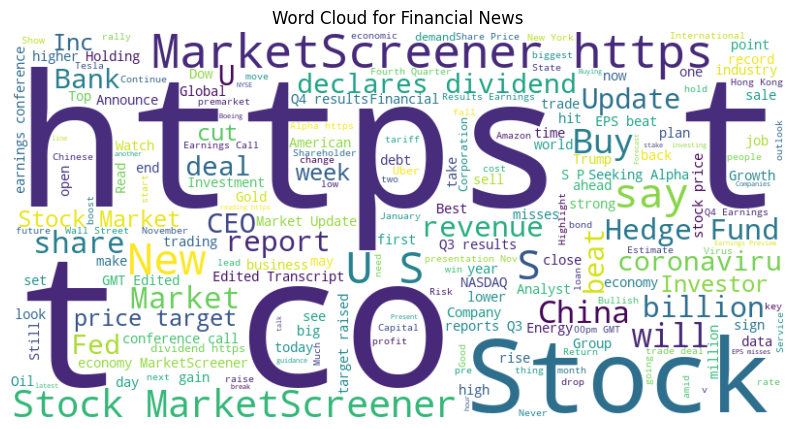

In [7]:
text_data = ' '.join(X_train)

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Financial News')
plt.show()


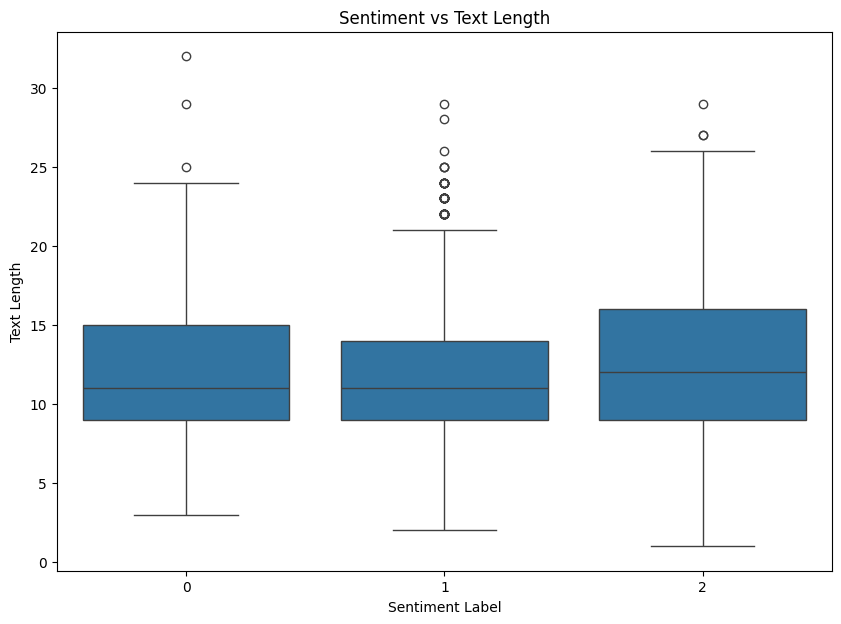

In [8]:
X_train = pd.Series(X_train)
X_val = pd.Series(X_val)

text_length = X_train.apply(lambda x: len(x.split()))
sentiment_length_df = pd.DataFrame({'Sentiment': y_train, 'Text Length': text_length})

# Plot the scatter plot
plt.figure(figsize=(10, 7))
sns.boxplot(x='Sentiment', y='Text Length', data=sentiment_length_df)
plt.title('Sentiment vs Text Length')
plt.xlabel('Sentiment Label')
plt.ylabel('Text Length')
plt.show()


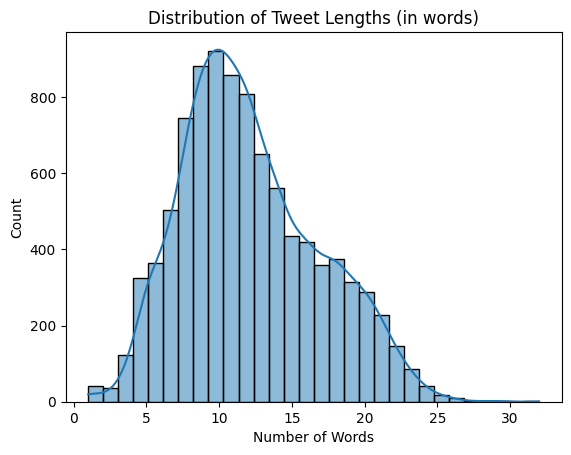

In [9]:
 
text_lengths = [len(text.split()) for text in X_train]

# Plot the distribution of tweet lengths
sns.histplot(text_lengths, bins=30, kde=True)
plt.title('Distribution of Tweet Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()


In [10]:
nltk.download('stopwords')
nltk.download('wordnet')
 
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove URLs, mentions, hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove non-alphanumeric characters
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    
    # Convert text to lowercase, remove stopwords, and lemmatize
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    
    return text
 
X_train = pd.Series(X_train)
X_val = pd.Series(X_val)

 
X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ariga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ariga/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

 
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)


### Support Vector Machine Algorithm

In [12]:
svm_model = SVC(kernel='linear')  

# Train the model
svm_model.fit(X_train_tfidf, y_train)

 
y_pred_svm = svm_model.predict(X_val_tfidf)
 
svm_accuracy = accuracy_score(y_val, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy:.4f}")
 
classification_rep = classification_report(y_val, y_pred_svm)

 
conf_matrix = confusion_matrix(y_val, y_pred_svm)
print(conf_matrix)
 

# Print all metrics
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print("\nClassification Report:")
print(classification_rep)
 


SVM Accuracy: 0.8095
[[ 167   33  147]
 [  27  281  167]
 [  29   52 1485]]
SVM Accuracy: 0.8095

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.48      0.59       347
           1       0.77      0.59      0.67       475
           2       0.83      0.95      0.88      1566

    accuracy                           0.81      2388
   macro avg       0.78      0.67      0.71      2388
weighted avg       0.80      0.81      0.80      2388



### Hyperparameter Tuning

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'C': 1, 'max_iter': -1, 'tol': 0.001}
Tuned SVM Accuracy: 0.8095
[[ 167   33  147]
 [  27  281  167]
 [  29   52 1485]]

Classification Report (Tuned SVM):
              precision    recall  f1-score   support

           0       0.75      0.48      0.59       347
           1       0.77      0.59      0.67       475
           2       0.83      0.95      0.88      1566

    accuracy                           0.81      2388
   macro avg       0.78      0.67      0.71      2388
weighted avg       0.80      0.81      0.80      2388



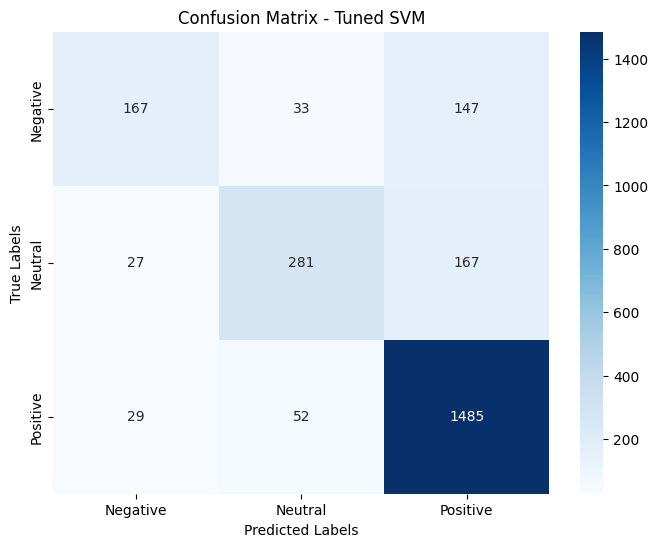

Mean Test Score: 0.6619 | Params: {'C': 0.1, 'max_iter': 1000, 'tol': 0.001}
Mean Test Score: 0.6619 | Params: {'C': 0.1, 'max_iter': 1000, 'tol': 0.0001}
Mean Test Score: 0.6619 | Params: {'C': 0.1, 'max_iter': 1000, 'tol': 1e-05}
Mean Test Score: 0.6473 | Params: {'C': 0.1, 'max_iter': 5000, 'tol': 0.001}
Mean Test Score: 0.6473 | Params: {'C': 0.1, 'max_iter': 5000, 'tol': 0.0001}
Mean Test Score: 0.6473 | Params: {'C': 0.1, 'max_iter': 5000, 'tol': 1e-05}
Mean Test Score: 0.6473 | Params: {'C': 0.1, 'max_iter': -1, 'tol': 0.001}
Mean Test Score: 0.6473 | Params: {'C': 0.1, 'max_iter': -1, 'tol': 0.0001}
Mean Test Score: 0.6473 | Params: {'C': 0.1, 'max_iter': -1, 'tol': 1e-05}
Mean Test Score: 0.6720 | Params: {'C': 1, 'max_iter': 1000, 'tol': 0.001}
Mean Test Score: 0.6720 | Params: {'C': 1, 'max_iter': 1000, 'tol': 0.0001}
Mean Test Score: 0.6720 | Params: {'C': 1, 'max_iter': 1000, 'tol': 1e-05}
Mean Test Score: 0.6827 | Params: {'C': 1, 'max_iter': 5000, 'tol': 0.001}
Mean Test

In [13]:
param_grid = {
    'C': [0.1, 1, 10, 100], 
    'tol': [1e-3, 1e-4, 1e-5],  
    'max_iter': [1000, 5000, -1],  
}

 
grid_search = GridSearchCV(estimator=SVC(kernel='linear'), 
                           param_grid=param_grid, 
                           cv=5,   
                           scoring='accuracy',  
                           verbose=1,  
                           n_jobs=-1)  

 
grid_search.fit(X_train_tfidf, y_train)

 
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
 
best_svm_model = grid_search.best_estimator_
 
y_pred_svm_tuned = best_svm_model.predict(X_val_tfidf)

 
svm_accuracy_tuned = accuracy_score(y_val, y_pred_svm_tuned)
print(f"Tuned SVM Accuracy: {svm_accuracy_tuned:.4f}")
 
conf_matrix_tuned = confusion_matrix(y_val, y_pred_svm_tuned)
print(conf_matrix_tuned)
 
classification_rep_tuned = classification_report(y_val, y_pred_svm_tuned)
print("\nClassification Report (Tuned SVM):")
print(classification_rep_tuned)
 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Tuned SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

 
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(f"Mean Test Score: {mean_score:.4f} | Params: {params}")


### XGBoost Algorithm

In [14]:
dtrain = xgb.DMatrix(X_train_tfidf, label=y_train)
dval = xgb.DMatrix(X_val_tfidf, label=y_val)

# Set the parameters for XGBoost
params = {
    'objective': 'multi:softmax',   
    'num_class': len(set(y_train)),  
    'eval_metric': 'merror',  
    'max_depth': 6,  
    'learning_rate': 0.1,  
 }

 
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

 
y_pred_xgb = xgb_model.predict(dval)
 
xgb_accuracy = accuracy_score(y_val, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")


XGBoost Accuracy: 0.7659


In [15]:
 
# Confusion matrix for the XGBoost model
conf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)
print("Confusion Matrix:")
print(conf_matrix_xgb)

 
class_report_xgb = classification_report(y_val, y_pred_xgb)
print("\nClassification Report:")
print(class_report_xgb)

# Compute accuracy
xgb_accuracy = accuracy_score(y_val, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Precision, Recall, F1-score for each class
precision_xgb = precision_score(y_val, y_pred_xgb, average=None)
recall_xgb = recall_score(y_val, y_pred_xgb, average=None)
f1_xgb = f1_score(y_val, y_pred_xgb, average=None)

print("\nPrecision for each class:")
print(precision_xgb)

print("\nRecall for each class:")
print(recall_xgb)

print("\nF1-Score for each class:")
print(f1_xgb)
 


Confusion Matrix:
[[ 102   23  222]
 [   7  195  273]
 [   8   26 1532]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.29      0.44       347
           1       0.80      0.41      0.54       475
           2       0.76      0.98      0.85      1566

    accuracy                           0.77      2388
   macro avg       0.81      0.56      0.61      2388
weighted avg       0.78      0.77      0.73      2388

XGBoost Accuracy: 0.7659

Precision for each class:
[0.87179487 0.79918033 0.75579674]

Recall for each class:
[0.29394813 0.41052632 0.97828863]

F1-Score for each class:
[0.43965517 0.54242003 0.85276927]


In [16]:
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")



SVM Accuracy: 0.8095
XGBoost Accuracy: 0.7659


In [17]:
print("SVM Classification Report",classification_rep)
print("XGBoost Classification Report",class_report_xgb)

SVM Classification Report               precision    recall  f1-score   support

           0       0.75      0.48      0.59       347
           1       0.77      0.59      0.67       475
           2       0.83      0.95      0.88      1566

    accuracy                           0.81      2388
   macro avg       0.78      0.67      0.71      2388
weighted avg       0.80      0.81      0.80      2388

XGBoost Classification Report               precision    recall  f1-score   support

           0       0.87      0.29      0.44       347
           1       0.80      0.41      0.54       475
           2       0.76      0.98      0.85      1566

    accuracy                           0.77      2388
   macro avg       0.81      0.56      0.61      2388
weighted avg       0.78      0.77      0.73      2388



### Key insights

- SVM performs better in terms of overall accuracy (0.8095 vs 0.7725 for XGBoost).
- XGBoost has higher precision for Class 0 (0.87 vs. 0.75 for SVM), but it struggles with recall for the same class (0.29 vs. 0.48 for SVM).
- Class 2 (likely the most common class) is well-recognized by both models, but SVM performs better in this category with a higher recall (0.95 vs. 0.98) and F1-score (0.88 vs. 0.85).
- SVM shows better overall balance between classes, whereas XGBoost is biased towards Class 2, resulting in a higher recall but much lower recall for the other classes.
- The weighted average F1-score for SVM (0.80) is higher than that of XGBoost (0.73), indicating better general performance across all classes.

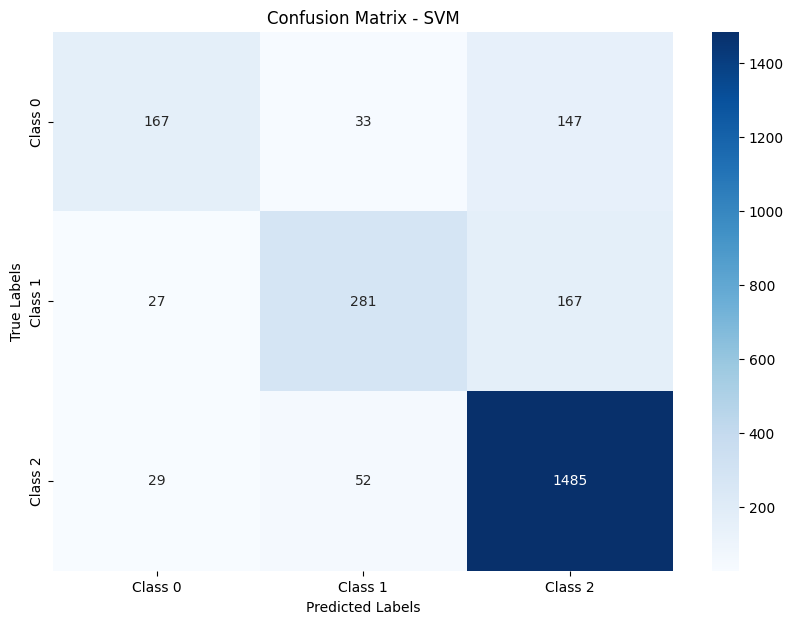

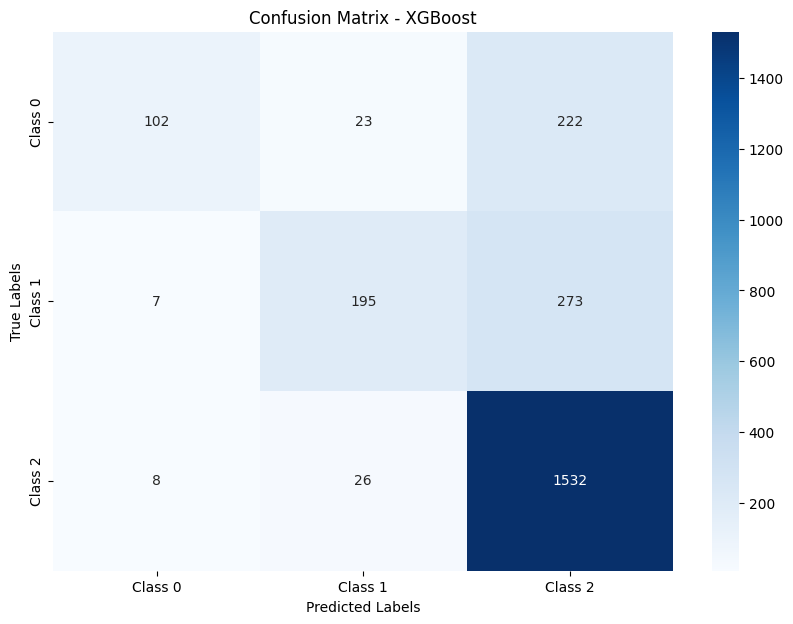

In [18]:
 
# 1. Confusion Matrix for SVM
plt.figure(figsize=(10, 7))
cm_svm = confusion_matrix(y_val, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# 2. Confusion Matrix for XGBoost
plt.figure(figsize=(10, 7))
cm_xgb = confusion_matrix(y_val, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", "Class 2"], yticklabels=["Class 0", "Class 1", "Class 2"])
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

 

### Comparison:
- SVM:
    The confusion matrix for SVM shows that it performs better with Class 2, where most of the predictions are accurate. However, it struggles with Classes 0 and 1, as there are several misclassifications.
- XGBoost:
    The confusion matrix for XGBoost shows it has more confusion between Class 0 and Class 2, but it is more successful than SVM in predicting Class 1, with fewer misclassifications.